In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

from Flow import *
from Model import Model
from NN import NN
from estimator import MonteCarlo, ImportanceSampling, AdaptiveImportanceSampling

In [2]:
def g(x):    
    mask = (x >= -1) & (x < 0)
    out = 1/2 * (np.sin(2*np.pi*x)**3 - 1) * mask
    out[~mask] = 1/2 * (np.sin(2*np.pi*x[~mask])**3 + 1)
    return out

In [3]:
sigma_noise = 0.1
N_train = 32

noise = tf.random.normal((N_train, 1), 0, sigma_noise)

X_train = np.random.uniform(-1, 1, (N_train, 1))
Y_train = g(X_train) + noise

In [4]:
prior = tfp.distributions.Normal(-10, 10)
likelihood = tfp.distributions.Normal(0, 1e-1)

gw = NN(input = 1, output = 1, hidden = 1, hidden_units=20, activation = tf.sin)
model = Model(X_train = X_train, Y_train = Y_train, gw = gw, prior = prior, likelihood = likelihood)

In [5]:
M = 20
lr = 1e-2
epochs = 500
q0 = tfp.distributions.Uniform(-2, 2)

flow = GradientFlow(M = M, epochs = epochs, lr = lr, model = model, q0 = q0)
w, logq = flow.flow_and_distribution()

500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 117ms/step


In [6]:
x_pred = np.linspace(-1, 1, 100).reshape(-1, 1)

est = ImportanceSampling(model = model, samples_weight = w, logq = logq)
mean, var = est.estimate(x_pred = x_pred)

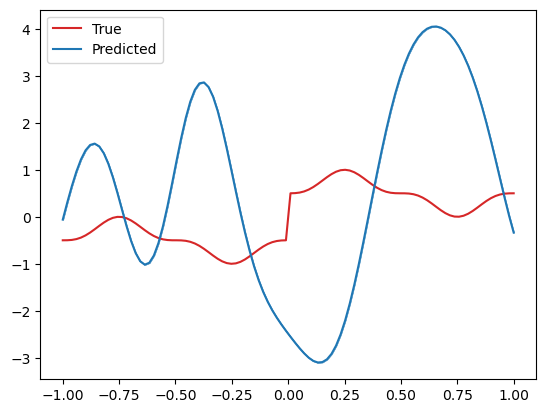

In [10]:
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.plot(np.linspace(-1, 1, 100), g(np.linspace(-1, 1, 100)), label = "True", color = "tab:red")
    ax.plot(np.linspace(-1, 1, 100), mean[frame], label = "Predicted", color = "tab:blue")
    ax.fill_between(np.linspace(-1, 1, 100), mean[frame] - np.sqrt(var[frame]), mean[frame] + np.sqrt(var[frame]), alpha = 0.5, color = "tab:blue")
    ax.legend()

    return ax,


ani = animation.FuncAnimation(fig, update, frames = 500, interval = 10)
rc('animation', html='html5')

In [ ]:
ani